In [10]:
# import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('Dataset .csv')  # load the dataset
print(data.head()) # display the first few rows
print(data.info()) #display dataset info
print(data.describe())
print(data.isnull().sum())  # check for missing values 

   Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mandaluyong City   
3      SM 

In [2]:
# drop unnecessary columns that are not relevant to prediction
columns_to_drop=['Restaurant ID', 'City', 'Address', 'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Rating color', 'Rating text', 'Switch to order menu']
data=data.drop(columns=columns_to_drop)
data['Cuisines'].fillna('Unknown') # fill missing values
# convert binary categorical variables to numerical
binary_columns=['Has Table booking', 'Has Online delivery', 'Is delivering now']
for col in binary_columns:
  data[col]=data[col].apply(lambda x:0 if x=='No' else 1)
print(data.head())

          Restaurant Name  Country Code                          Cuisines  \
0        Le Petit Souffle           162        French, Japanese, Desserts   
1        Izakaya Kikufuji           162                          Japanese   
2  Heat - Edsa Shangri-La           162  Seafood, Asian, Filipino, Indian   
3                    Ooma           162                   Japanese, Sushi   
4             Sambo Kojin           162                  Japanese, Korean   

   Average Cost for two          Currency  Has Table booking  \
0                  1100  Botswana Pula(P)                  1   
1                  1200  Botswana Pula(P)                  1   
2                  4000  Botswana Pula(P)                  1   
3                  1500  Botswana Pula(P)                  0   
4                  1500  Botswana Pula(P)                  1   

   Has Online delivery  Is delivering now  Price range  Aggregate rating  \
0                    0                  0            3               4.8   


In [3]:
# define target variable and features
X=data.drop(columns=['Aggregate rating'])
y=data['Aggregate rating']
# define categorical and numerical columns
categorical_features=['Cuisines', 'Currency', 'Country Code']
numerical_features=['Average Cost for two', 'Price range', 'Votes']
# preprocessing pipeline
preprocessor=ColumnTransformer(
    transformers=[
         ('n', StandardScaler(), numerical_features),
         ('c', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=50)
print(f"Training set size: {X_train.shape}") 
print(f"Testing set size: {X_test.shape}")                 

Training set size: (7640, 10)
Testing set size: (1911, 10)


In [4]:
# define the model pipeline
model=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=10, random_state=50))
])
# train the model
model.fit(X_train, y_train)
print(preprocessor)

ColumnTransformer(transformers=[('n', StandardScaler(),
                                 ['Average Cost for two', 'Price range',
                                  'Votes']),
                                ('c', OneHotEncoder(handle_unknown='ignore'),
                                 ['Cuisines', 'Currency', 'Country Code'])])


In [150]:
# make predictions on the test set
y_pred=model.predict(X_test)
# evaluate the model
MSE=mean_squared_error(y_test, y_pred)
MAE=mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)
print(f"Mean squared error: {MSE:.2f}")
print(f"Mean absolute error: {MAE:.2f}")
print(f"R-squared score: {r2:.2f}")

Mean squared error: 0.12
Mean absolute error: 0.23
R-squared score: 0.95


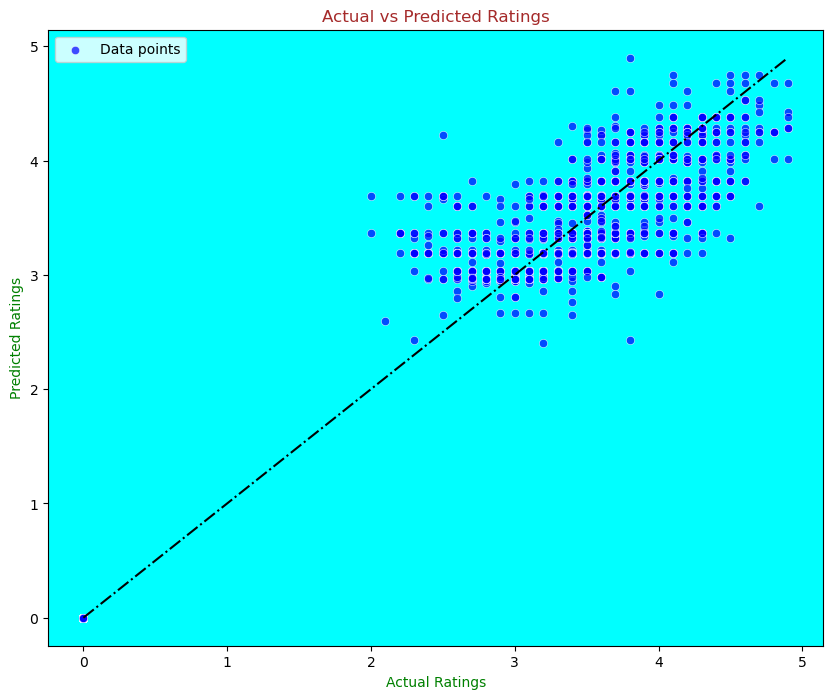

In [160]:
# plot actual vs predicted ratings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, marker='o', color='blue', label='Data points')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='dashdot')
plt.gca().set_facecolor('aqua')
plt.xlabel("Actual Ratings", color='green')
plt.ylabel("Predicted Ratings", color='green')
plt.title("Actual vs Predicted Ratings", color='brown')
plt.legend()
plt.show()


Feature Importance:
                                                Feature  Importance
2                                              n__Votes    0.979109
1551                     c__Currency_Indian Rupees(Rs.)    0.010044
0                               n__Average Cost for two    0.001883
1                                        n__Price range    0.001242
1549                              c__Currency_Dollar($)    0.001010
...                                                 ...         ...
568                   c__Cuisines_Continental, European    0.000000
567   c__Cuisines_Continental, Chinese, Thai, Mughla...    0.000000
566   c__Cuisines_Continental, Chinese, Thai, Medite...    0.000000
565   c__Cuisines_Continental, Chinese, North Indian...    0.000000
787                                    c__Cuisines_Goan    0.000000

[1574 rows x 2 columns]


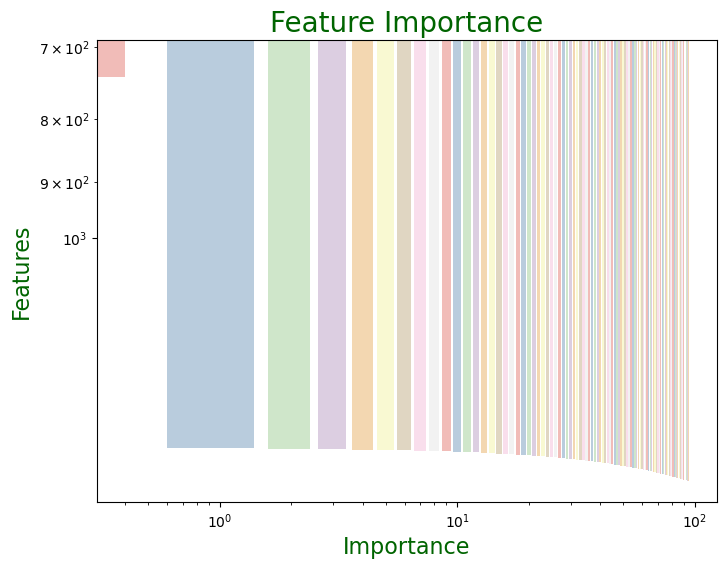

In [148]:
    # display feature importance
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    feature_importance=model.named_steps['regressor'].feature_importances_
    feature_names=model.named_steps['preprocessor'].get_feature_names_out()
    if len(feature_names)==len(feature_importance):
        importance_df=pd.DataFrame({
          'Feature':feature_names, 
          'Importance':feature_importance
        })
        importance_df=importance_df.sort_values(by='Importance', ascending=False)
        print("\nFeature Importance:")
        print(importance_df)
        # plot feature importance
        plt.figure(figsize=(8, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df, orient="v", palette='Pastel1')
        plt.title("Feature Importance", color='darkgreen', fontsize=20)
        plt.xlabel("Importance", color='darkgreen', fontsize=16)
        plt.ylabel("Features", color='darkgreen', fontsize=16)
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
    else:
         print(error)

# Conclusion: 
# 1-High r2 score(0.95) indicates the model explains 95% of the variance in restaurant ratings. 
# 2-Low MSE and MAE indicates the errors between actual and predicted ratings are minimal. 
# 3-Feature importance indicates features like n__Votes and c__Currency_Indian Rupees(Rs.) heavily influence the ratings. 